In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

print(sys.executable)

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

from tqdm.notebook import tqdm

/home/conor/miniconda3/envs/PHD/bin/python


In [3]:
Data = pd.read_pickle(os.path.join(os.getcwd(), "merged_data"))

In [4]:
Data.shape

(301, 12)

In [5]:
Data["Team_1_win_test"] = np.random.randint(0,1,Data.shape[0])

In [6]:
Data["Team_1_win_test"] = np.random.random(Data.shape[0])

In [7]:
def prob_convert(frac_odds):
    
    num, denom = np.array(frac_odds.split("/"), dtype = int)
    
    return denom/(num+denom)

def dec_convert(frac_odds):
    
    num, denom = np.array(frac_odds.split("/"), dtype = int)
    
    return num/denom

In [8]:
Data["Prob_1"] = [prob_convert(odds) for odds in Data["team_1_odds"]]
Data["Prob_2"] = [prob_convert(odds) for odds in Data["team_2_odds"]]

Data["Dec_1"] = [dec_convert(odds) for odds in Data["team_1_odds"]]
Data["Dec_2"] = [dec_convert(odds) for odds in Data["team_2_odds"]]

In [9]:
Data

,Score,Team_1,Team_2,team_1_odds,team_2_odds,Prob_1,Prob_2,T1_win,Day,Rounds,dire,radiant,Team_1_win_test,Dec_1,Dec_2
0,0:2,PSG.LGD,Evil Geniuses,61/100,137/100,0.621118,0.421941,0,17,"[{'Radiant_win': False, 'radiant_hero_names': ...",Evil Geniuses,PSG.LGD,0.771410,0.61,1.37
1,0:2,PSG.LGD,Evil Geniuses,27/50,71/50,0.649351,0.413223,0,17,"[{'Radiant_win': False, 'radiant_hero_names': ...",Evil Geniuses,PSG.LGD,0.966591,0.54,1.42
2,0:2,Team Secret,VGJ.Storm,33/100,9/4,0.751880,0.307692,0,16,"[{'Radiant_win': True, 'radiant_hero_names': [...",VGJ.Storm,Team Secret,0.815208,0.33,2.25
3,2:0,Team Liquid,LGD Gaming,79/100,23/25,0.558659,0.520833,1,12,"[{'Radiant_win': True, 'radiant_hero_names': [...",LGD Gaming,Team Liquid,0.045979,0.79,0.92
4,2:1,Newbee,LGD.Forever Young,139/100,14/25,0.418410,0.641026,1,11,"[{'Radiant_win': True, 'radiant_hero_names': [...",LGD.Forever Young,Newbee,0.370010,1.39,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0:2,Fnatic,OG,77/100,51/50,0.564972,0.495050,0,4,"[{'Radiant_win': False, 'radiant_hero_names': ...",OG,Fnatic,0.618339,0.77,1.02
297,2:0,Team Secret,Chaos Esports Club,13/100,493/100,0.884956,0.168634,1,4,"[{'Radiant_win': True, 'radiant_hero_names': [...",Chaos Esports Club,Team Secret,0.439330,0.13,4.93
298,1:2,Keen Gaming,Team Liquid,173/100,11/25,0.366300,0.694444,0,4,"[{'Radiant_win': True, 'radiant_hero_names': [...",Team Liquid,Keen Gaming,0.464161,1.73,0.44
299,1:2,Ninjas in Pyjamas,Chaos Esports Club,27/50,36/25,0.649351,0.409836,0,4,"[{'Radiant_win': True, 'radiant_hero_names': [...",Chaos Esports Club,Ninjas in Pyjamas,0.874147,0.54,1.44


In [10]:
def roc_plot(y_true, y_pred):
    
    fpr, tpr, t = roc_curve(y_true, y_pred)
    AUC = roc_auc_score(y_true, y_pred)

    scores = np.array([np.sqrt(((1-t)**2)+((0-(f))**2)) for f, t in zip(fpr,tpr)])
    threshi = np.argmin(scores)

    prec, rec, _ = precision_recall_curve(y_true, y_pred)

    opt = t[threshi]
    
    fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))

    ax.plot(fpr, tpr)
    ax.plot([0,1],[0,1], linestyle = '--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ECS ROC Curve')
    ax.plot([0, fpr[threshi]], [1, tpr[threshi]], linestyle = "--")
    ax.text(0.8, 0.2, f"AUC {AUC:.2f}")

    ax2.plot(rec, prec)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision Recall Curve')
    
    return fig

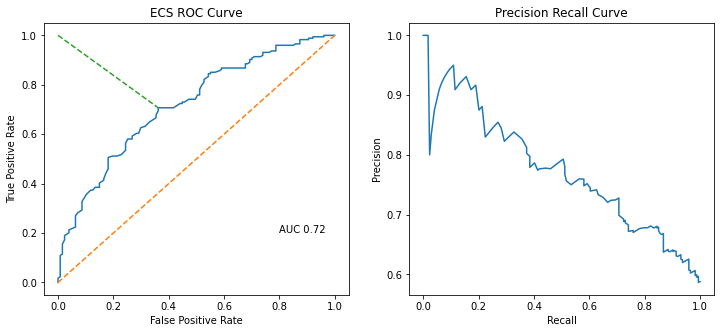

In [11]:
roc_plot(Data["T1_win"], Data["Prob_1"]);

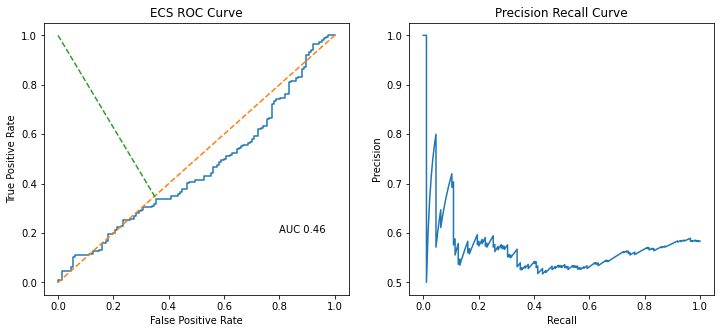

In [12]:
roc_plot(Data["T1_win"], Data["Team_1_win_test"]);

In [13]:
def simulate(Data, balance):
    
    output = []
    
    for i , row in Data.iterrows():
        
        match_stats = dict()
        match_stats['balance'] = balance

        # I think team 1 wins
        if row.Team_1_win_test > 0.5:
            
            print(i)

            # Calclate optimal stake using Kelly criterion
            frac = ((row.Team_1_win_test*(row.Dec_1+1))-1)/row.Dec_1
            
            frac = (((row.Dec_1-1)*row.Team_1_win_test)-(1-row.Team_1_win_test))/(row.Dec_1-1)
            match_stats['frac'] = frac

            stake = frac*balance
            match_stats["stake"] = stake
            
            if frac < 0: 
                stake = 0
                
            #if row.Team_1_win_test < 0.4: stake = 0

            # team 1 wins
            if row.T1_win == 1:

                profit = stake * row.Dec_1
                balance = balance + stake + profit

            # if team 2 wins
            else:
                balance = balance - stake

        # I think team 2 wins
        else:
            
            print(i)

            # Calclate optimal stake using Kelly criterion
            frac = (((1-row.Team_1_win_test)*(row.Dec_2+1))-1)/row.Dec_2
            
            frac = (((row.Dec_2-1)*row.Team_1_win_test)-(1-row.Team_1_win_test))/(row.Dec_2-1)
            match_stats['frac'] = frac
            
            stake = frac*balance
            match_stats["stake"]
            
            if frac < 0:
                stake = 0
                
            #if row.Team_1_win_test < 0.4: stake = 0

            # team 2 wins
            if row.T1_win == 0:

                profit = stake * row.Dec_2
                balance = balance + stake + profit

            # if team 2 wins
            else:
                balance = balance - stake

        balances.append(balance)
        
    return balances

In [14]:
def kelly(b, p):
    # Calculate Kelly criterion
    
    return (p*(b+1)-1)/b



def simulate_2(Data, start_balance, kelly_frac):
    
    balance = start_balance
    
    rows = []

    # Iterate through every match
    for i, row in Data.iterrows():
        
        results = dict()
        
        # Calculate Kelly criterion for each possible bet
        kelly1 = kelly(row.Dec_1, row.Team_1_win_test)
        kelly2 = kelly(row.Dec_2, 1-row.Team_1_win_test)
        
        # Do we have a viable bet?
        if np.max([kelly1, kelly2]) > 0:
            
            bet_choice = np.argmax([kelly1, kelly2])
            
            # Calculate stake given the best kelly score
            stake = balance * np.max([kelly1, kelly2]) * kelly_frac

            stake if stake < 1 else 1

            #results["stake"] = stake
            
            # Stupidly they have to be opposite but whatever
            # Did team 1 win and i pick team 1 OR team 2 win and I pic?
            if (row.T1_win == 1 and bet_choice == 0) or (row.T1_win == 0 and bet_choice == 1):
                
                profit = stake*balance
                balance = balance + profit

            else:
                balance = balance - stake
        else:
            stake=0
        
        rows.append({
            "Balance":balance,
            "Stake"  :stake
        })
    
    return pd.DataFrame(rows)

In [15]:
Data.sample(3)

,Score,Team_1,Team_2,team_1_odds,team_2_odds,Prob_1,Prob_2,T1_win,Day,Rounds,dire,radiant,Team_1_win_test,Dec_1,Dec_2
254,2:0,Evil Geniuses,Ninjas in Pyjamas,11/25,7/4,0.694444,0.363636,1,19,"[{'Radiant_win': True, 'radiant_hero_names': [...",Ninjas in Pyjamas,Evil Geniuses,0.792952,0.44,1.75
292,2:0,Team Liquid,Keen Gaming,59/100,127/100,0.628931,0.440529,1,5,"[{'Radiant_win': True, 'radiant_hero_names': [...",Keen Gaming,Team Liquid,0.809644,0.59,1.27
291,0:2,Chaos Esports Club,Ninjas in Pyjamas,181/100,19/100,0.355872,0.840336,0,5,"[{'Radiant_win': False, 'radiant_hero_names': ...",Ninjas in Pyjamas,Chaos Esports Club,0.023154,1.81,0.19


In [16]:
Data["Team_1_win_test"] = np.random.random(Data.shape[0])

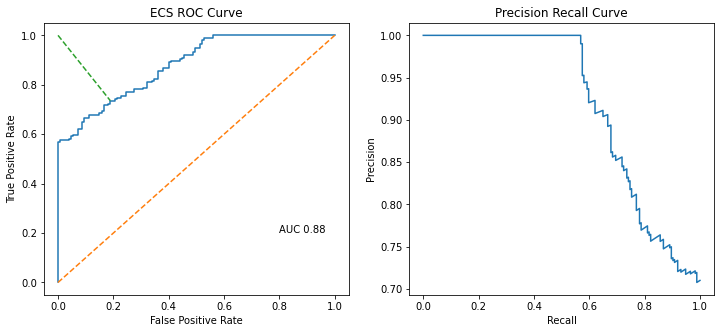

In [21]:
roc_plot(Data["T1_win"], Data["Team_1_win_test"]);

In [30]:
Data["Team_1_win_test"] = [np.random.uniform(0.40, 0.55) if result == 0 else np.random.uniform(0.45, 0.55) for result in Data["T1_win"]]
#Data["Team_1_win_test"] = Data["Team_1_win_test"] + [np.random.uniform(0,0.75) if result == 0 else np.random.uniform(0.25,1) for result in Data["T1_win"]]
#Data["Team_1_win_test"] = (Data["Team_1_win_test"]/Data["Team_1_win_test"].max()) + Data["Team_1_win_test"].min()

<AxesSubplot:>

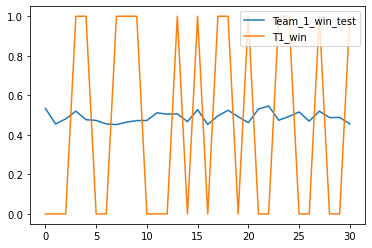

In [31]:
Data.loc[:30,["Team_1_win_test", "T1_win"]].plot()

In [34]:
results = pd.concat({f"Run {i+1}":simulate_2(Data.sample(frac = 1), 1, 0.2) for i in tqdm(range(20))}, axis = 1)

n=results.shape[1]

results.iloc[:,np.arange(0,n,2)].T.mean().plot(logy = True, ls='--',label='Mean',c='r')
sns.lineplot(data=results.iloc[:,np.arange(0,n,2)])

ax.set_ylabel("Balance")
ax.set_xlabel("Bet event number")
plt.legend()

<AxesSubplot:xlabel='Bet event number', ylabel='Balance'>

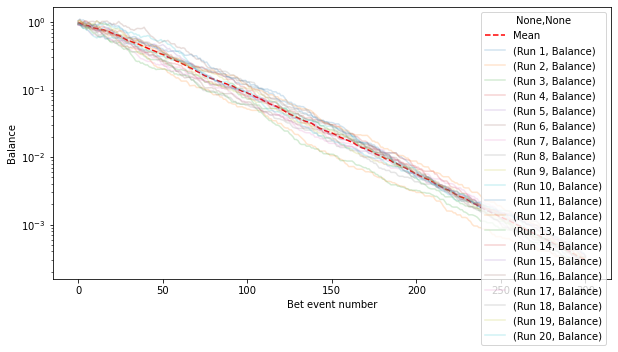

In [35]:
n=results.shape[1]


ax=results.iloc[:,np.arange(0,n,2)].T.mean().plot(logy = True, ls='--',label='Mean',c='r')
ax.set_ylabel("Balance")
ax.set_xlabel("Bet event number")
plt.legend()
results.iloc[:,np.arange(0,n,2)].plot(ax=ax, logy = True, figsize = (10,5), label = False, alpha=0.2)

In [24]:
def simulate(Data, balance):
    
    balance = balance
    balances = []
    
    for i , row in Data.iterrows():

        # I think team 1 wins
        if row.Team_1_win_test > 0.5:

            # Calclate optimal stake using Kelly criterion
            frac = ((row.Team_1_win_test*(row.Dec_1+1))-1)/row.Dec_1
            
            frac = (((row.Dec_1-1)*row.Team_1_win_test)-(1-row.Team_1_win_test))/row.Dec_1-1

            stake = frac*balance

            if frac < 0: 
                stake = 0
                
            #if row.Team_1_win_test < 0.4: stake = 0

            # team 1 wins
            if row.T1_win == 1:

                profit = stake * row.Dec_1
                balance = balance + stake + profit

            # if team 2 wins
            else:
                balance = balance - stake

        # I think team 2 wins
        else:

            # Calclate optimal stake using Kelly criterion
            frac = (((1-row.Team_1_win_test)*(row.Dec_2+1))-1)/row.Dec_2
            
            frac = (((row.Dec_2-1)*row.Team_1_win_test)-(1-row.Team_1_win_test))/row.Dec_2-1
            
            stake = frac*balance

            if frac < 0:
                stake = 0
                
            #if row.Team_1_win_test < 0.4: stake = 0

            # team 2 wins
            if row.T1_win == 0:

                profit = stake * row.Dec_2
                balance = balance + stake + profit

            # if team 2 wins
            else:
                balance = balance - stake

        balances.append(balance)
        
    return balances

In [26]:
Data

,Score,Team_1,Team_2,team_1_odds,team_2_odds,Prob_1,Prob_2,T1_win,Day,Rounds,dire,radiant,Team_1_win_test,Dec_1,Dec_2
0,0:2,PSG.LGD,Evil Geniuses,61/100,137/100,0.621118,0.421941,0,17,"[{'Radiant_win': False, 'radiant_hero_names': ...",Evil Geniuses,PSG.LGD,0,0.61,1.37
1,0:2,PSG.LGD,Evil Geniuses,27/50,71/50,0.649351,0.413223,0,17,"[{'Radiant_win': False, 'radiant_hero_names': ...",Evil Geniuses,PSG.LGD,0,0.54,1.42
2,0:2,Team Secret,VGJ.Storm,33/100,9/4,0.751880,0.307692,0,16,"[{'Radiant_win': True, 'radiant_hero_names': [...",VGJ.Storm,Team Secret,0,0.33,2.25
3,2:0,Team Liquid,LGD Gaming,79/100,23/25,0.558659,0.520833,1,12,"[{'Radiant_win': True, 'radiant_hero_names': [...",LGD Gaming,Team Liquid,1,0.79,0.92
4,2:1,Newbee,LGD.Forever Young,139/100,14/25,0.418410,0.641026,1,11,"[{'Radiant_win': True, 'radiant_hero_names': [...",LGD.Forever Young,Newbee,1,1.39,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0:2,Fnatic,OG,77/100,51/50,0.564972,0.495050,0,4,"[{'Radiant_win': False, 'radiant_hero_names': ...",OG,Fnatic,0,0.77,1.02
297,2:0,Team Secret,Chaos Esports Club,13/100,493/100,0.884956,0.168634,1,4,"[{'Radiant_win': True, 'radiant_hero_names': [...",Chaos Esports Club,Team Secret,1,0.13,4.93
298,1:2,Keen Gaming,Team Liquid,173/100,11/25,0.366300,0.694444,0,4,"[{'Radiant_win': True, 'radiant_hero_names': [...",Team Liquid,Keen Gaming,0,1.73,0.44
299,1:2,Ninjas in Pyjamas,Chaos Esports Club,27/50,36/25,0.649351,0.409836,0,4,"[{'Radiant_win': True, 'radiant_hero_names': [...",Chaos Esports Club,Ninjas in Pyjamas,0,0.54,1.44


In [27]:
results = pd.DataFrame([simulate(Data.sample(frac = 1), balance = 1) for _ in range(10)]).T

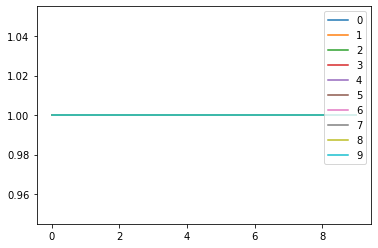

In [28]:
results.iloc[:10].plot()

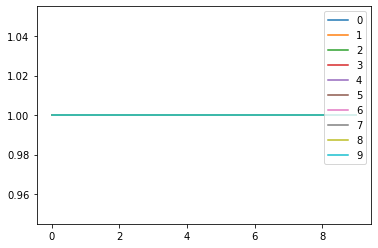

In [29]:
results.iloc[:10].plot()

In [30]:
from tqdm.notebook import tqdm

In [31]:
results = dict()

for thresh in tqdm(np.arange(0,1,0.1)):
    
    Data["Team_1_win_test"] = [np.random.uniform(0,0.5) if result == 0 else np.random.uniform(0.5,1) for result in Data["T1_win"]]
    
    # Add noise to the destimate
    Data["Team_1_win_test"] = Data["Team_1_win_test"] + np.random.uniform(0, thresh,len(Data["T1_win"]))
    
    # Run the simulation a few times with shuffled events
    results[thresh] = pd.DataFrame([simulate(Data.sample(frac = 1), balance = 1000) for _ in range(20)])
    
results = pd.concat(results, names = ["Thresh"])

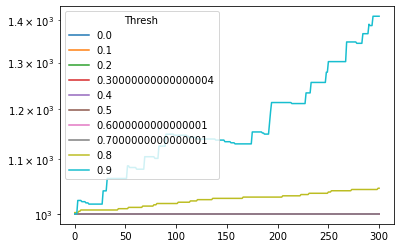

In [32]:
results.groupby("Thresh").mean().T.plot(logy = True)

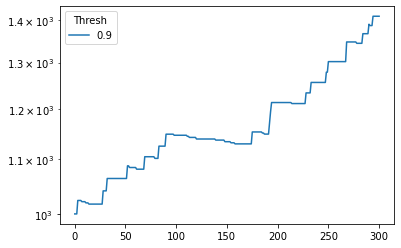

In [33]:
results.query("Thresh == 0.9").groupby("Thresh").mean().T.plot(logy = True)

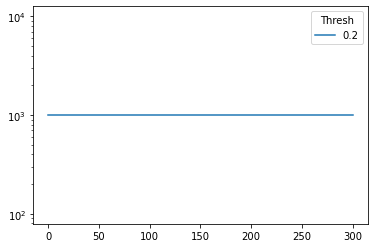

In [34]:
results.query("Thresh == 0.2").groupby("Thresh").mean().T.plot(logy = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8aa5f59c50>]],
      dtype=object)

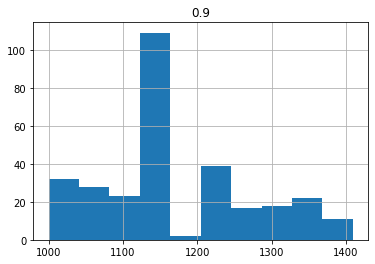

In [35]:
results.query("Thresh == 0.9").groupby("Thresh").mean().T.hist()